# Traffic Network speed data prediction using LSTM

LSTM is a special kind of recurrent neural network. The major difference between LSTM and RNN is that LSTM has a special mechanism called **forget gate**. As RNNs do, LSTMs also have **hidden state** that would pass to the next time slot. But not like RNN, iformations are selected through the forget gate and only let through those informations that is usefull. Let see how this would help LSTM get away from gradient vanish or gradient explode.

### Input gate in LSTM
First, the input is squashed between -1 and 1 using a tanh activation function. This can be expressed by:

$$g = tanh(b^g+x_tU^g+y_{t-1}V^g)$$

Where **$U^g$** and **$V^g$** are the weights for the input and previous cell output, respectively, and **$b^g$** is the input bias. Note that the exponents **g** are not a raised power, but rather signify that these are the input weights and bias values (as opposed to the input gate, forget gate, output gate etc.).

This squashed input is then multiplied element-wise by the output of the input gate. The input gate is basically a hidden layer of sigmoid activated nodes, with weighted **$x_t$** and **$y_{t-1}$** input values, which outputs values of between 0 and 1 and when multiplied element-wise by the input determines which inputs are switched on and off. In other words, it is a kind of input filter or gate. The expression for the input gate is:

$$i = \sigma(b^i + x_tU^i+ y_{t-1}V^i)$$

### The hidden state and the forget gate
Forget gate is again a sigmoid activated set of nodes which is element-wise multiplied by the hidden state of the previous moment **$s_{t-1}$** to determine which previous states should be remembered (i.e. forget gate output close to 1) and which should be forgotten (i.e. forget gate output close to 0). This allows the LSTM cell to learn appropriate context. The forget gate is like:

$$f = \sigma(b^f + x_tU^f + y_{t-1}V^i)$$

So the hidden state of the current moment is:

$$s_t = s_{t-1}\circ f + g \circ i$$

Where $\circ$ denotes element-wise multiplication.

### The output gate in LSTM

The final stage of the LSTM cell is the output gate. The output gate has two components – another tanh squashing function and an output sigmoid gating function. The output sigmoid gating function, like the other gating functions in the cell, is multiplied by the squashed state st to determine which values of the state are output from the cell. 

The output gate is like:

$$o = \sigma(b^o + x_tU^o + y_{t-1}V^o)$$

So the final output of the cell is:

$$y_t = tanh(s_t)\circ o$$

### Dropout
The **dropout** reduce the chance of overfitting by adding noise to the inputs. It does this by discarding some elements in the input with certain rate $dropout$. 

* For elements which are discarded, **dropout** makes theirs values equal 0.
* For elements which are reserved, **dropout** scales their initial value by $\frac{1}{1-dropout}$.

The summation of the inputs remains unchanged.

# Traffic network speed dataset
The dataset is an open source Guangzhou speed dataset which can be found on my GitHub repository Transpol：https://github.com/Vadermit/TransPOL. This dataset contains the mean speed of 214 roads in Guangzhou. The data is collected every 5min from 8:00 to 20:00 for 2 months. Each raod has a temporal series of length $8784 = (30 + 31)\times\frac{60}{5}\times12$.

In [1]:
# LSTM for international airline passengers problem with regression framing
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
tensor = scipy.io.loadmat('../Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('../Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('../Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
print(dense_mat.shape)

(214, 8784)


# Network speed data prediction using LSTM
Each raod has its distinctive characteristics. But for computation efficiency, we only train one LSTM network to perform speed prediction in the whole road network.

### Data normalize
LSTMs are very sensitive to the scale of their inputs, especially when using activations like tanh and sigmoid. Imaging this, if the inputs to an activation function are too big or too small, the derivative of tanh or sigmoid activation function would be 0. That means those weights related to that activation won't be updated according to the chain rule.

So, before we feed the raw data into the LSTM network, we need to normalize those inputs and their labels to standard normal distribution as follows:

$$\hat{x}_i = \frac{x_i - x_{min}}{x_{max} - x_{min}}$$

The same $x_{max}$ and $x_{min}$ will be used again to restore the scale and position of predictions.

$$x_i = \hat{x}_i \times (x_{max} - x_{min}) + x_{min}$$

Since the concentrarion data scale of different pollutants observed from different stations are quite different, so they are scaled seperately using sklearn tool `MinMaxScalar`. `MinMaxScalar` is used to conveniently calculate the `min` and `max` of each feature of inital data `X` of size **[sample_num, feature_num]**. ($x_{max}$ and $x_{min}$ are calculated for each feature seperately)

Our `dense_mat` is a 214 by 8784 matrix. Here, we can see it as a dataset of 8784 samples(time slots) and each sample contains 214 features(different roads). So the data scaling can be done as:

In [3]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaleDataset = scaler.fit_transform(dense_mat.T).T
print('Size of scaleDataset:')
print(scaleDataset.shape)
print()
print('Scaled data:')
print(scaleDataset[:5, :5])

Size of scaleDataset:
(214, 8784)

Scaled data:
[[0.79588401 0.81787383 0.86332646 0.87142797 0.86488363]
 [0.82551033 0.84004516 0.8201337  0.87101457 0.87483198]
 [0.57426059 0.57135092 0.60031974 0.57626432 0.61762856]
 [0.74110297 0.74543006 0.69533734 0.77973773 0.82042564]
 [0.82445465 0.8243344  0.7983357  0.87221915 0.87702927]]


## Seperating training set  and test set

In [4]:
test_rate = 0.3

train_len = int((1 - test_rate) * scaleDataset.shape[1])
test_len = scaleDataset.shape[1] - train_len
training_set = scaleDataset[:, :train_len]
test_set = scaleDataset[:, train_len:]
print('The size of training set is:')
print(training_set.shape)
print()
print('The size of test set is:')
print(test_set.shape)

The size of training set is:
(214, 6148)

The size of test set is:
(214, 2636)


## Generate inputs and labels
**back_step** is the number of previous observations used in performing the prediction.

In [5]:
def create_samples(dataset, back_step = 1):
    dataX, dataY = [], []
    for item in range(dataset.shape[0]):
        for t in range(dataset.shape[1] - back_step):
            a = dataset[item, t:(t + back_step)]
            dataX.append(a)
            dataY.append(dataset[item, t + back_step])
    return np.array(dataX), np.array(dataY)

In [7]:
def create_samples(dataset, time_lags):
    dataX, dataY = [], []
    back_step = np.max(time_lags)
    for item in range(dataset.shape[0]):
        for t in range(back_step, dataset.shape[1]):
            a = dataset[item, t - time_lags]
            dataX.append(a)
            dataY.append(dataset[item, t])
    return np.array(dataX), np.array(dataY)

Set prediction backstep to be $12 \times 60 / 5= 144$ (Use observations of the previous week to make predictions). 

In [9]:
back_step = 144 # 12*60/5
time_lags = np.array([1,2,144])
trainX, trainY = create_samples(training_set, time_lags)
testX, testY = create_samples(test_set, time_lags)
print('Size of training X:')
print(trainX.shape)
print('Size of training Y:')
print(trainY.shape)
print()
print('Size of testing X:')
print(testX.shape)
print('Size of testing Y:')
print(testY.shape)

Size of training X:
(1284856, 3)
Size of training Y:
(1284856,)

Size of testing X:
(533288, 3)
Size of testing Y:
(533288,)


### Reshape inputs to shape of [samples, time_steps, features]

In [10]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print('Shape of trainX:')
print(trainX.shape)
print('Shape of testX:')
print(testX.shape)
print('Shape of trainY:')
print(trainY.shape)
print('Shape of testY:')
print(testY.shape)
# print('The first 5 elements in trainX are:')
# print(trainX[:5][:][:])

Shape of trainX:
(1284856, 3, 1)
Shape of testX:
(533288, 3, 1)
Shape of trainY:
(1284856,)
Shape of testY:
(533288,)


### Reshape inputs to shape of [samples, time_steps, features]

In [11]:
# reshape input to be [samples, time steps, features]
keras_trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
keras_testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# trainY = np.reshape(trainY, (trainY.shape[0], 1, 1))
# testY = np.reshape(testY, (testY.shape[0], 1, 1))
print('Shape of keras_trainX:')
print(keras_trainX.shape)
print('Shape of keras_testX:')
print(keras_testX.shape)
print('Shape of trainY:')
print(trainY.shape)
print('Shape of testY:')
print(testY.shape)
print('The first 5 elements in trainX are:')
print(keras_trainX[:2,:5,0])

Shape of keras_trainX:
(1284856, 3, 1)
Shape of keras_testX:
(533288, 3, 1)
Shape of trainY:
(1284856,)
Shape of testY:
(533288,)
The first 5 elements in trainX are:
[[0.84539792 0.84152603 0.79588401]
 [0.80291234 0.84539792 0.81787383]]


## Neural network setup and training
The network consists of three LSTM networks and a full connected layer. Each of the LSTM layer has 10 hidden units. Two dropout layers are added after each of the LSTM layers. 

In [13]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape = (len(time_lags), 1), return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(10, input_shape = (len(time_lags), 10), return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(10, input_shape = (len(time_lags), 10)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(keras_trainX, trainY, epochs=20, batch_size=10, verbose=2)

Epoch 1/20
 - 520s - loss: 0.0045
Epoch 2/20
 - 524s - loss: 0.0040
Epoch 3/20
 - 527s - loss: 0.0039
Epoch 4/20
 - 527s - loss: 0.0039
Epoch 5/20
 - 525s - loss: 0.0039
Epoch 6/20
 - 524s - loss: 0.0039
Epoch 7/20
 - 527s - loss: 0.0038
Epoch 8/20
 - 525s - loss: 0.0038
Epoch 9/20
 - 525s - loss: 0.0038
Epoch 10/20
 - 524s - loss: 0.0038
Epoch 11/20
 - 525s - loss: 0.0038
Epoch 12/20
 - 525s - loss: 0.0038
Epoch 13/20
 - 527s - loss: 0.0038
Epoch 14/20
 - 524s - loss: 0.0038
Epoch 15/20
 - 524s - loss: 0.0038
Epoch 16/20
 - 525s - loss: 0.0038
Epoch 17/20
 - 524s - loss: 0.0038
Epoch 18/20
 - 525s - loss: 0.0038
Epoch 19/20
 - 526s - loss: 0.0038
Epoch 20/20
 - 525s - loss: 0.0038


### Using trained model to make predictions
Using the afore-trained model to make predictions both in the training set and the test set.

In [14]:
# make predictions
trainPredict = model.predict(keras_trainX)
testPredict = model.predict(keras_testX)

### Reshape predictions to size [sample_num, feature_num]
Recall that we used the sklearn tool `MinMaxScalar` to normalize the concentration data of different kinds of pollutants from different stations seperately. `MinMaxScalar` function requires samples of size **[sample_num, feature_num]**. Here, **sample_num** is the number of time slots in the dataset(or predictions) and **feature_num** is the number of different pollutants from different observation stations which is 27 in our problem setting($4 \times 8 - 5 = 27$).

So, to denormalize those predictions, we need to reshape the predictions to size **[predict_time, 27]**.

In [16]:
def reshapepred(predictions, feature_num):
    time_num = np.int(len(predictions) / feature_num)
    pred_mat = np.zeros((time_num, feature_num))
    for t in range(time_num):
        for item in range(feature_num):
            pred_mat[t, item] = predictions[item * time_num + t]
    return pred_mat

In [22]:
train_pred_mat = reshapepred(trainPredict, 214)
test_pred_mat = reshapepred(testPredict, 214)
print('The size of train_pred_mat:')
print(train_pred_mat.shape)
print()
print('The size of test_pred_mat:')
print(test_pred_mat.shape)

The size of train_pred_mat:
(6004, 214)

The size of test_pred_mat:
(2492, 214)


#### Reshape real values to shape [pred_time_num, feature_num]

In [23]:
training_real_value = training_set[:, back_step:].T
test_real_value = test_set[:, back_step:].T
print('The size of training_real_value:')
print(training_real_value.shape)
print()
print('The size of test_real_value:')
print(test_real_value.shape)

The size of training_real_value:
(6004, 214)

The size of test_real_value:
(2492, 214)


### Denormalize of predictions
As we trained the network using normalized data, the datas we predicted are also normalized. Now we want to denormalize them.

In [24]:
# invert predictions
descale_trainPredict = scaler.inverse_transform(train_pred_mat)
descale_trainY = scaler.inverse_transform(training_real_value)
descale_testPredict = scaler.inverse_transform(test_pred_mat)
descale_testY = scaler.inverse_transform(test_real_value)
print(descale_testPredict.shape)
# print(descale_testPredict[:5, 0])
print(descale_testY.shape)
# print(descale_testY[0, :5])

(2492, 214)
(2492, 214)


In [25]:
print('10 first real value on test set')
print(descale_testY[:10,0])
print()
print('10 first prediciton on test set:')
print(descale_testPredict[:10,0])

10 first real value on test set
[28.609 22.81  20.459 21.862 10.57  11.069 12.005 13.571 12.509 11.214]

10 first prediciton on test set:
[29.32066255 28.56704194 23.08668891 20.60876873 22.16327217 15.23679403
 14.51099738 15.04803977 16.08451985 15.13808738]


### Calculate the prediction error
RMSE(root mean squared error) for both training set and test set are calculated in the following code:

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def root_mean_squared_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

In [27]:
# calculate root mean squared error
trainScore_rmse = root_mean_squared_error(descale_trainY, descale_trainPredict)
print('Train Score: %.2f RMSE' % (trainScore_rmse))
trainScore_mape = mean_absolute_percentage_error(descale_trainY, descale_trainPredict)
print('Train Score: %.2f%% MAPE' % (trainScore_mape))
print()
testScore_rmse = root_mean_squared_error(descale_testY, descale_testPredict)
print('Test Score: %.2f RMSE' % (testScore_rmse))
testScore_mape = mean_absolute_percentage_error(descale_testY, descale_testPredict)
print('Test Score: %.2f%% MAPE' % (testScore_mape))

Train Score: 2.95 RMSE
Train Score: inf% MAPE

Test Score: 3.02 RMSE
Test Score: 6.75% MAPE


/home/jamie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


### Discussion: What the rmse would be if using current value as predict value?

In [28]:
dummy_rmse_train = math.sqrt(mean_squared_error(descale_trainY[1:descale_trainY.shape[0]][:], descale_trainY[0: descale_trainY.shape[0] - 1][:]))
dummy_mape_train = mean_absolute_percentage_error(descale_trainY[1:descale_trainY.shape[0]][:], descale_trainY[0: descale_trainY.shape[0] - 1][:])
print('Dummy RMSE on training set: %.2f RMSE' % (dummy_rmse_train))
print('Dummy MAPE on training set: %.2f%% MAPE' % (dummy_mape_train))
print()
dummy_rmse_test = math.sqrt(mean_squared_error(descale_testY[1:descale_testY.shape[0]][:], descale_testY[0: descale_testY.shape[0] - 1][:]))
dummy_mape_test = mean_absolute_percentage_error(descale_testY[1:descale_testY.shape[0]][:], descale_testY[0: descale_testY.shape[0] - 1][:])
print('Dummy RMSE on training set: %.2f RMSE' % (dummy_rmse_test))
print('Dummy MAPE on training set: %.2f%% MAPE' % (dummy_mape_test))

Dummy RMSE on training set: 3.12 RMSE
Dummy MAPE on training set: nan% MAPE

Dummy RMSE on training set: 3.21 RMSE
Dummy MAPE on training set: 6.76% MAPE


/home/jamie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jamie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


### Real value and predicted value visualization

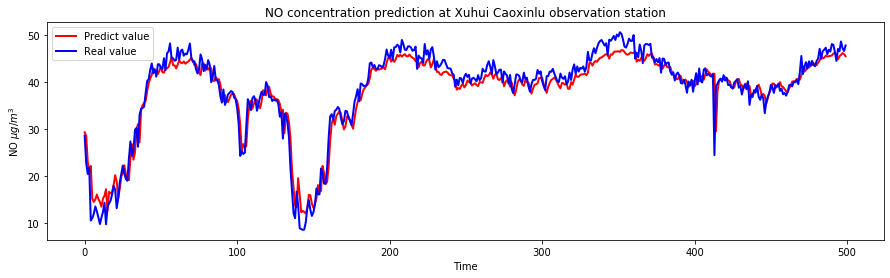

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 4))
pollutant = 0
start_time = 0
end_time = 500
plt.plot(descale_testPredict[start_time:end_time, pollutant], label = 'Predict value', marker='', markerfacecolor='blue', markersize=8, color='red', linewidth=2)
plt.plot(descale_testY[start_time:end_time, pollutant], label = 'Real value', marker='', markerfacecolor='blue', markersize=8, color='blue', linewidth=2)
plt.title('NO concentration prediction at Xuhui Caoxinlu observation station')
plt.xlabel('Time')
plt.ylabel('NO $\mu g/m^3$')
plt.legend()
plt.show()

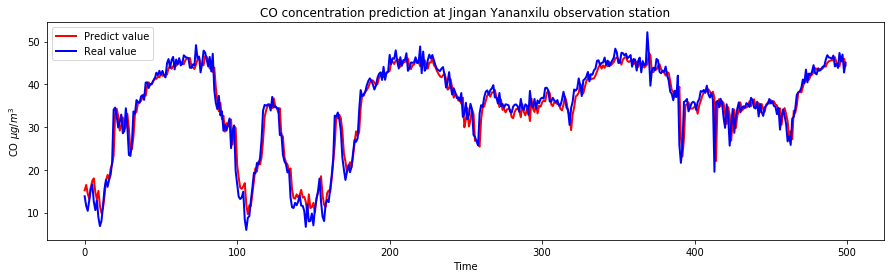

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 4))
pollutant = 11
start_time = 0
end_time = 500
plt.plot(descale_testPredict[start_time:end_time, pollutant], label = 'Predict value', marker='', markerfacecolor='blue', markersize=8, color='red', linewidth=2)
plt.plot(descale_testY[start_time:end_time, pollutant], label = 'Real value', marker='', markerfacecolor='blue', markersize=8, color='blue', linewidth=2)
plt.title('CO concentration prediction at Jingan Yananxilu observation station')
plt.xlabel('Time')
plt.ylabel('CO $\mu g/m^3$')
plt.legend()
plt.show()